In [1]:
import matplotlib.pyplot as plt
# from lsst.rsp import get_tap_service
# import numpy as np
# import imageio
# import pandas as pd
# import os
# import astropy.units as u
# from astropy.table import Table
# from astropy.coordinates import SkyCoord
# from astropy.wcs import WCS

# from matplotlib.patches import Circle
# import time
# import gc
# import zipfile
# import sys

# from lsst.daf.butler import Butler
# from lsst.daf.butler.registry import ConflictingDefinitionError
# import lsst.daf.base as dafBase

# import lsst.afw.display as afwDisplay
# import lsst.afw.table as afwTable
# import lsst.geom as geom
# import lsst.sphgeom

# from lsst.source.injection import ingest_injection_catalog, generate_injection_catalog
# from lsst.source.injection import VisitInjectConfig, VisitInjectTask

# from lsst.pipe.tasks.registerImage import RegisterConfig, RegisterTask
# from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask

# from lsst.meas.algorithms.detection import SourceDetectionTask
# from lsst.meas.deblender import SourceDeblendTask
# from lsst.meas.base import SingleFrameMeasurementTask
# from lsst.meas.base import ForcedMeasurementTask


### Calexp test

In [2]:
from exposures import Calexp
dataId = {'visit': 211199, 'detector': 139, 'band': 'i'}
calexp = Calexp(dataId)
dataId_ref = {'visit': 211488, 'detector': 103, 'band': 'i'}
calexp_ref = Calexp(dataId_ref)

In [3]:
help(calexp.expF)

Help on ExposureF in module lsst.afw.image._exposure object:

class ExposureF(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      ExposureF
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  Factory(self, *args, **kwargs) from lsst.afw.image._image._slicing.supportSlicing.<locals>
 |      Return an object of this type
 |  
 |  __add__ = notImplemented(self, other) from lsst.afw.image._image._disableArithmetic.wrapNotImplemented.<locals>
 |      Provide a helpful error message about image arithmetic
 |      
 |      Unless we're operating on an ImageSlice, in which case it might be
 |      defined.
 |      
 |      Parameters
 |      ----------
 |      self : subclass of `lsst.afw.image.ImageBase`
 |          Image someone's attempting to do arithmetic with.
 |      other : anything
 |          The operand of the arithmetic operation.
 |  
 |  __deepcopy__(self, memo=None) from lsst.afw.image._exposure._exposureC

In [4]:
print(calexp.calexp_data); print(calexp.expF)
ra, dec = calexp.pix_to_sky(500,500)
print("ra",ra,"dec",dec,type(ra))
x,y = calexp.sky_to_pix(ra, dec)
print("x", x,"y", y,type(x))
ra_corners, dec_corners = calexp.get_corners()
x_corners, y_corners = calexp.get_corners(coord="pix")
print("corners:", "ra", ra_corners, "dec", dec_corners)
print("corners:", "x", x_corners, "y", y_corners)
print(calexp.contains([50,62.2],[30,-36]))
print(calexp.contains(62.2,-36))
ra, dec = calexp.pix_to_sky(10,10)
print("ra",ra,"dec",dec,type(ra))
calexp.check_edge(62.13, -35.75), calexp.check_edge(62.12651,-35.7609, d=10), calexp.check_edge(ra, dec, d=80)

{'visit': 211199, 'detector': 139, 'band': 'i'}
ra 62.126516708328296 dec -35.76091834834366 <class 'float'>
x 500 y 500 <class 'int'>
corners: ra [62.11623355380292, 62.35102852509294, 62.20027281583327, 61.965180214050655] dec [-35.722526925706966, -35.84469113188991, -36.03510894183185, -35.91266882257578]
corners: x [0.0, 4072.0, 4072.0, 0.0] y [0.0, 0.0, 4072.0, 4072.0]
[False, True]
True
ra 62.11643911845412 dec -35.72329477933113 <class 'float'>


(False, False, True)

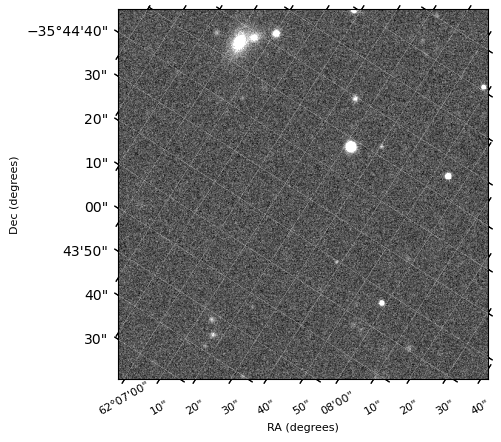

In [5]:
cutout = calexp.cutout(([62.2,-36], 500))
ax=cutout.plot()

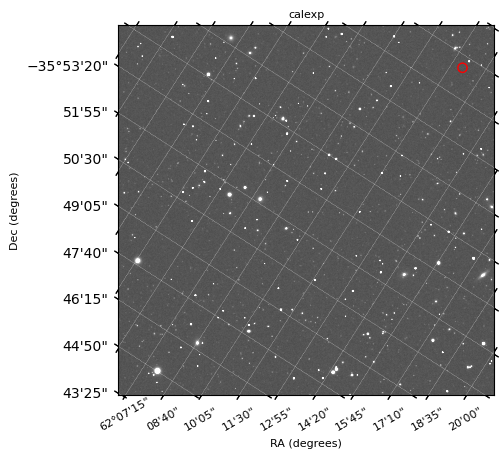

<Figure size 640x480 with 0 Axes>

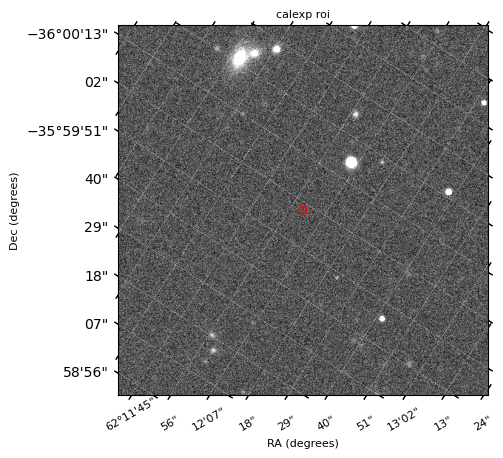

In [6]:
ax = calexp.plot(title="calexp")
calexp.add_point(ax,62.2, -36,r=50)
plt.figure()
ax = calexp.plot(title="calexp roi", roi = ([62.2,-36], 500))
calexp.add_point(ax,62.2, -36)

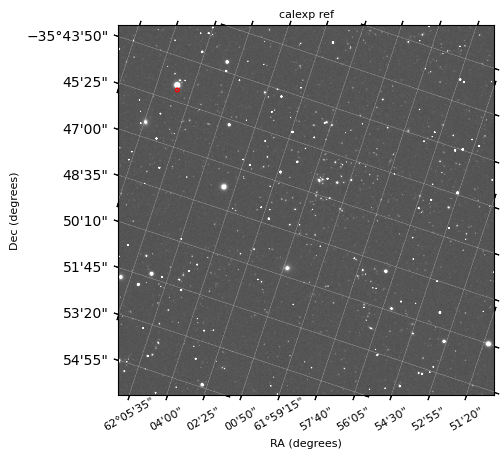

<Figure size 640x480 with 0 Axes>

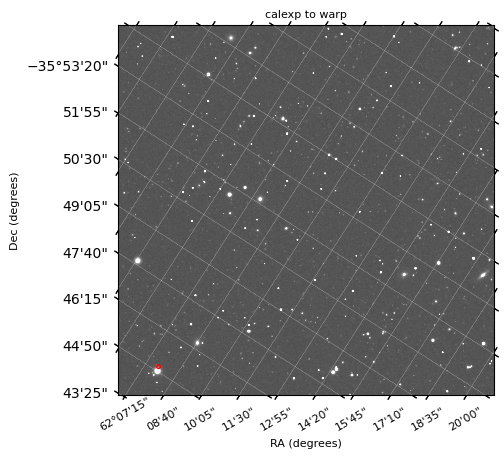

In [7]:
ax = calexp_ref.plot(title="calexp ref")
calexp_ref.add_point(ax,62.13, -35.75, r=20)
plt.figure()
ax = calexp.plot(title="calexp to warp")
calexp.add_point(ax,62.13, -35.75, r=20)

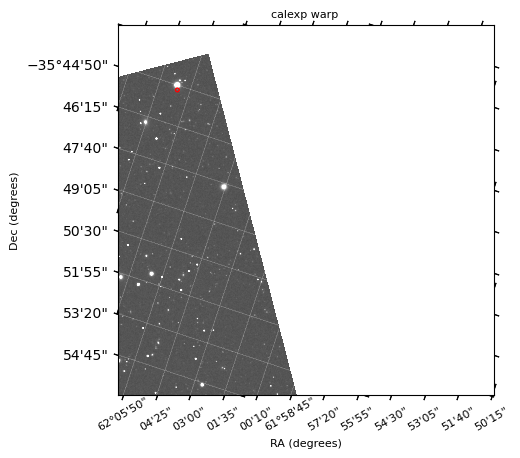

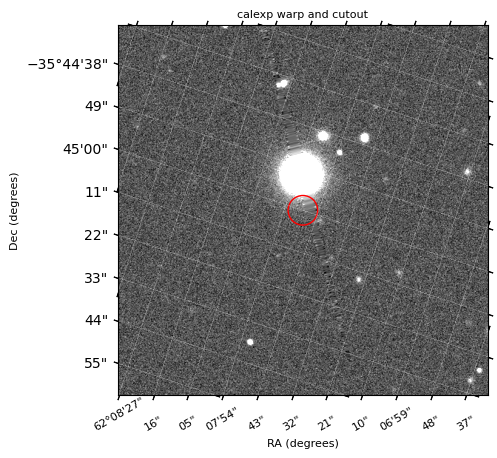

In [8]:
ax = calexp.plot(title="calexp warp ", warp=calexp_ref)
calexp_ref.add_point(ax,62.13, -35.75, r=40)
ax = calexp.plot(title="calexp warp and cutout", roi = ([62.13, -35.75], 500),warp=calexp_ref)
calexp_ref.add_point(ax,62.13, -35.75, r=20)

### Light curve test

In [1]:
from light_curves import LightCurve
lc = LightCurve(ra = 62.149, dec = -35.796)
lc.calculate_htm_id()
lc.collect_calexp()
params = {"t_0": 60700.5, "t_E": 30, "u_0": 0.5, "m_base": 19.5}
lc.simulate(params, model="Pacz", plot=False)
lc.data

(62.149, -35.796)   HTM ID=9645646590460 at level=20 is bounded by a circle of radius ~0.26 arcsec.


UnimplementedQueryError: Unsupported combination for spatial join: (SkyPixDimension(htm20), DatabaseDimensionCombination(visit_detector_region)).

In [5]:
lc.data.columns

Index(['Time', 'mag', 'mag_err', 'calexp_detector', 'calexp_visit'], dtype='object')

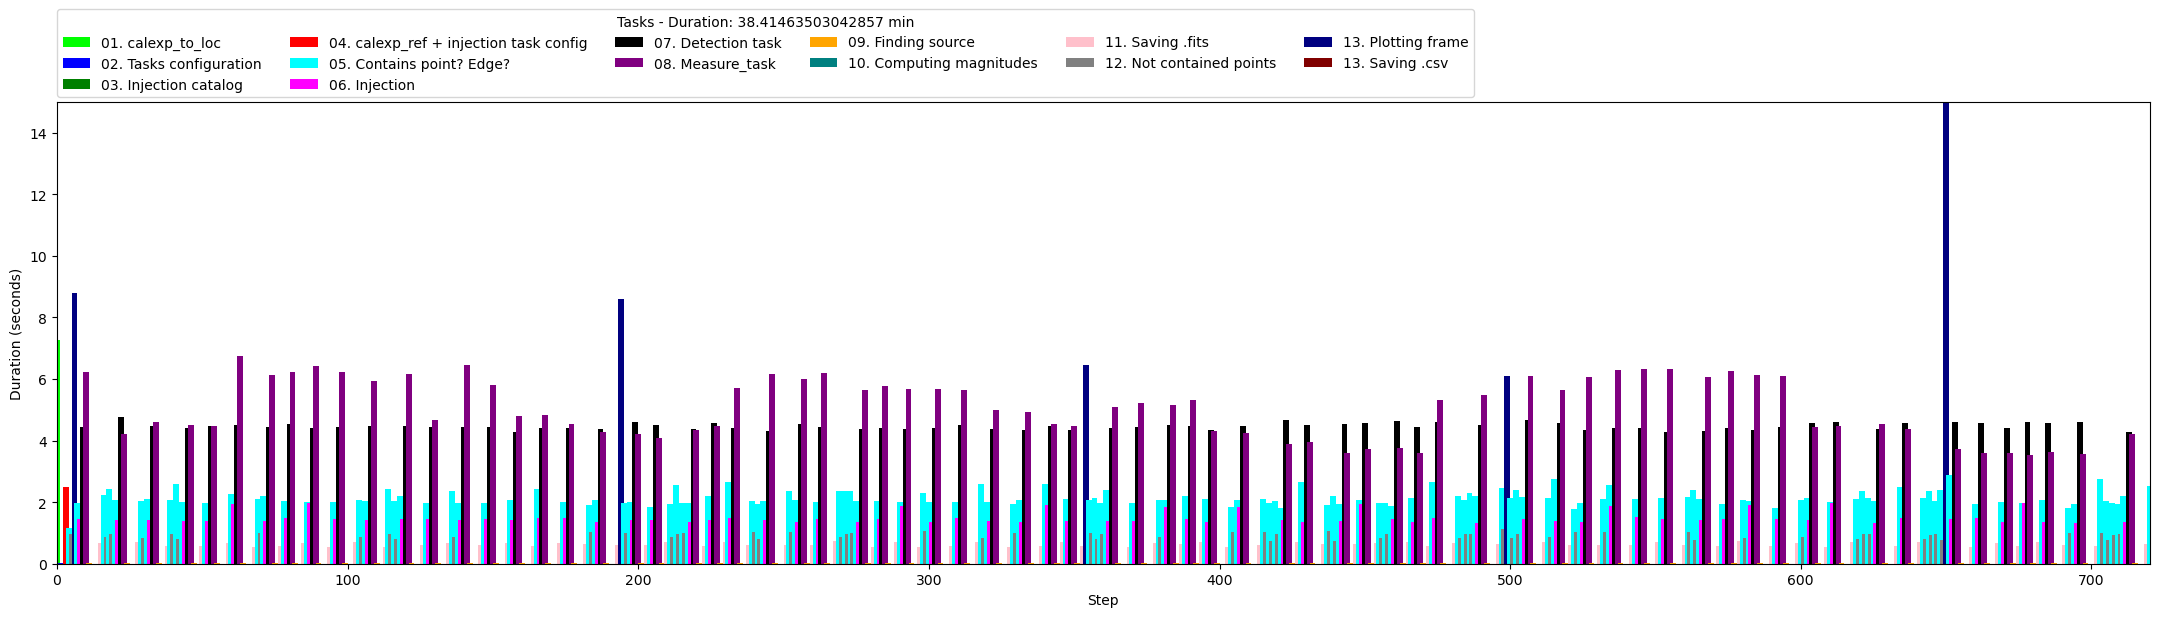

In [70]:
main_path = "runs/20241010_235458/"; n_points = 3; level = 10
df = pd.read_csv(f'{main_path}time_analysis-points{n_points}-HTMlevel{level}.csv')
duration = df["duration"].values
task = df["task"].values
# duration = [j - i for i, j in zip(times[:-1], times[1:])]
colors = ['lime', 'blue', 'green', 'red', 'cyan', 'magenta',  'black', 'purple', 'orange', 
          'teal', 'pink', 'gray', 'navy', 'maroon', 'olive', 'silver', 'aqua',
          'coral', 'turquoise', 'salmon', 'orchid',  'gold', 'plum','yellow', 'brown']
col_task = {i:j for i,j in zip(sorted(set(task)), colors[:len(task)])}
taskcolors=[col_task[i] for i in task]
plt.figure(figsize=(27,6))
plt.xlim(0,720)
plt.ylim(0,15)
plt.bar(range(len(duration)), duration, color=taskcolors, width=2)
for ta in sorted(col_task):
    plt.bar(0, 0, color=col_task[ta], label=ta)  # Barra invisible para crear la leyenda
plt.xlabel("Step")
plt.ylabel("Duration (seconds)")
plt.legend(title=f'Tasks - Duration: {np.sum(duration)/60} min',ncol=6, loc=(0, 1.01))
# data = np.column_stack((np.array([0]+duration, dtype=float), np.array(task, dtype=str)))
# np.savetxt('time_analysis.csv', data, delimiter=',', header="duration,task", comments='', fmt='%s')
plt.savefig(f'{main_path}time_analysis-points{n_points}-HTMlevel{level}.png', bbox_inches='tight')

In [54]:
config = RegisterConfig()
visit = 214463 #lc.data['calexp_visit'][p]
detector = 171 #lc.data['calexp_detector'][p]
dataId = {"visit": visit, "detector": detector}
calexp = butler.get('calexp', **dataId)
task = RegisterTask(name="register", config=config)
warped = task.warpExposure(calexp, calexp_ref.calexp.getWcs(), calexp.getWcs(),calexp_ref.getBBox())


In [53]:
help(task.warpExposure)

Help on method warpExposure in module lsst.pipe.tasks.registerImage:

warpExposure(inputExp, newWcs, templateWcs, templateBBox) method of lsst.pipe.tasks.registerImage.RegisterTask instance
    Warp input exposure to template frame.
    
    There are a variety of data attached to the exposure (e.g., PSF, PhotoCalib
    and other metadata), but we do not attempt to warp these to the template
    frame.
    
    Parameters
    ----------
    inputExp : `lsst.afw.image.Exposure`
        Input exposure, to be warped.
    newWcs : `lsst.afw.geom.SkyWcs`
        Revised Wcs for input exposure.
    templateWcs : `lsst.afw.geom.SkyWcs`
        Target Wcs.
    templateBBox : `lsst.geom.Box`
        Target bounding box.
    
    Returns
    -------
    alignedExp : `lsst.afw.image.Exposure`
        Warped exposure.



In [316]:
visit = lc.data['calexp_visit'][p]
detector = lc.data['calexp_detector'][p]

visit, detector

(214463, 171)

In [181]:
print(calexp_ref.calexp.getWcs().getPixelScale())
calexp_ref.calexp.getWcs()

9.69146e-07 rad


FITS standard SkyWcs:
Sky Origin: (62.0523444966, -35.8538383311)
Pixel Origin: (2193.55, 2037.03)
Pixel Scale: 0.199901 arcsec/pixel

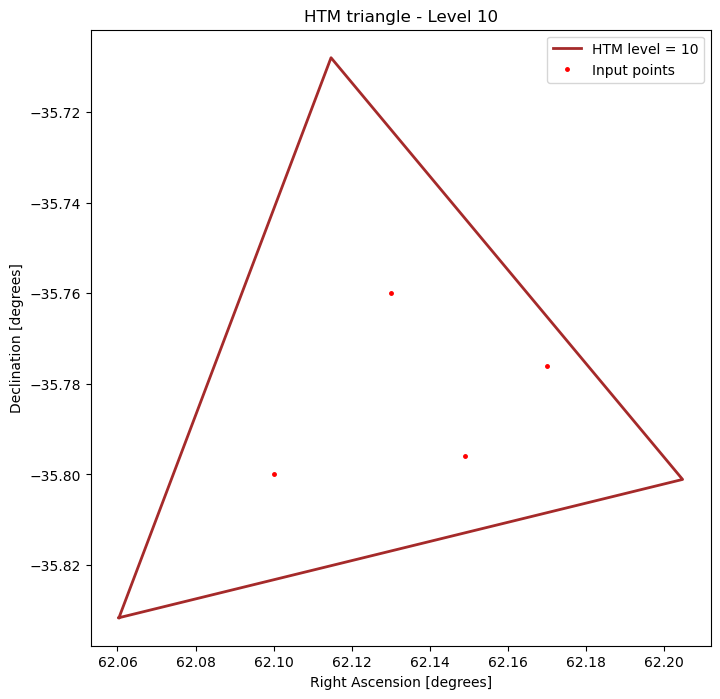

In [74]:
import itertools
from shapely.geometry import Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import lsst.sphgeom  # Asegúrate de tener el paquete adecuado

def plot_htm_and_points(level, ra_dec_list, color=None, circle=False, calexp=False, lwT=2, lwC=2, lwc=1):
    # Obtener el primer punto de la lista para generar el triángulo HTM
    ra, dec = ra_dec_list[0]
    
    # Crear el pixelizador HTM para el nivel dado
    pixelization = lsst.sphgeom.HtmPixelization(level)
    
    # Obtener el ID HTM del primer punto
    htm_id = pixelization.index(lsst.sphgeom.UnitVector3d(lsst.sphgeom.LonLat.fromDegrees(ra, dec)))
    
    # Obtener los vértices del triángulo HTM
    tri_ra_dec = []
    for uni in pixelization.triangle(htm_id).getVertices():
        tri_ra_dec.append([lsst.sphgeom.LonLat.longitudeOf(uni).asDegrees(), lsst.sphgeom.LonLat.latitudeOf(uni).asDegrees()])
    
    # Crear el polígono del triángulo HTM
    poli = Polygon(tri_ra_dec)
    x, y = poli.exterior.xy
    plt.plot(x, y, alpha=1, color=color, linewidth=lwT, label=f"HTM level = {level}")
    
    ret = []
    
    # Dibujar el círculo delimitador si se solicita
    if circle:
        bounding_circle = pixelization.triangle(htm_id).getBoundingCircle()
        center = bounding_circle.getCenter()
        ra_c, dec_c = lsst.sphgeom.LonLat.longitudeOf(center).asDegrees(), lsst.sphgeom.LonLat.latitudeOf(center).asDegrees()
        radius = bounding_circle.getOpeningAngle().asDegrees()
        circ = plt.Circle((ra_c, dec_c), radius, linewidth=lwC, linestyle="--", color=color, fill=False, label="Bounding circle")
        ret.append(circ)
    
    # Ploteo de los puntos (ra, dec) de la lista
    ra_points, dec_points = zip(*ra_dec_list)
    plt.plot(ra_points, dec_points, ".r", markersize=5, label="Input points")
    
    # Retornar las figuras adicionales si es necesario
    return ret

# Lista de puntos (ra, dec) para ploteo
ra_dec_list = [(62.149, -35.796), (62.1, -35.80), (62.13, -35.76), (62.17, -35.776)]  # Ejemplo de varios puntos

# Colores por nivel de HTM
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'orange', 'brown',
          'teal', 'pink', 'gray', 'gold', 'lime', 'navy', 'maroon', 'olive', 'silver', 'aqua',
          'coral', 'turquoise', 'salmon', 'orchid', 'plum']

# Ploteo para un nivel específico, por ejemplo, nivel 10
level = 10

# Crear la figura
plt.figure(figsize=(8,8))

# Llamada a la función para plotear el triángulo HTM y los puntos
plot_htm_and_points(level, ra_dec_list, color=colors[level-1])
# plot_htm_and_points(8, ra_dec_list, color=colors[5])

# Configurar etiquetas y leyenda
plt.title(f"HTM triangle - Level {level}")
plt.xlabel("Right Ascension [degrees]")
plt.ylabel("Declination [degrees]")
plt.legend(loc="best")

# Mostrar el gráfico
plt.show()
